In [2]:
import time
from typing import Any, Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import solve_continuous_are
from tqdm import tqdm
from IPython.display import HTML

from koopman.simulation.animation import PlotEnvironment
from koopman.simulation.systems import DynamicalSystem, Pendulum
from koopman.simulation.simulator import simulate
from spatialmath.base import angle_wrap

Simulation progress: 100%|██████████| 250/250 [00:00<00:00, 8009.35it/s]


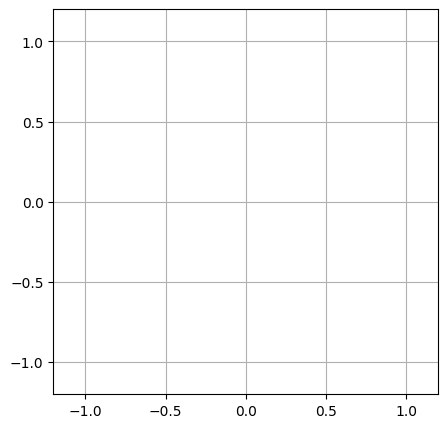

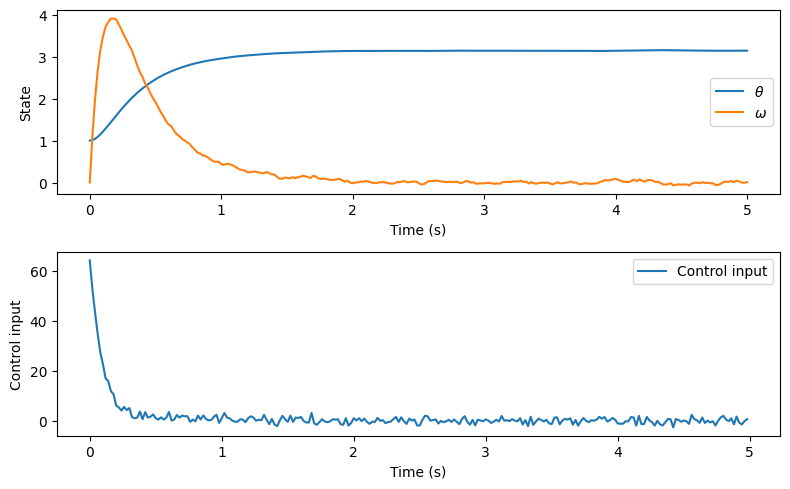

In [3]:
xd = np.array([np.pi, 0.0])  # Desired state
kp = np.diag([30.0, 10.0])

def control(t: float, x: np.ndarray) -> np.ndarray:
    """Control input for the pendulum system."""
    e = xd - x
    return np.array([np.sum(kp @ e)]) + np.random.normal(0, 1.0, size=(1,))


def simulate_pendulum():
    sys = Pendulum(Pendulum.Params(m=1, l=1, g=9.81, b=0.5))

    x0 = np.array([1.0, 0.0])
    tf = 5.0

    ts, xhist, uhist = simulate(sys, tf=tf, dt=0.02, u=control, x0=x0, log=True)

    # Render the simulation
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.grid(True)
    ax.set_aspect('equal')

    env = PlotEnvironment(fig, ax)
    env.add_element(Pendulum.PlotElement(env, sys))
    ani = env.render(t_range=(0, tf), fps=30)
    
    return ani, ts, xhist, uhist

ani, ts, xhist, uhist = simulate_pendulum()

fig, ax = plt.subplots(2, 1, figsize=(8, 5))
ax[0].plot(ts, xhist[:, 0], label=r'$\theta$')
ax[0].plot(ts, xhist[:, 1], label=r'$\omega$')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('State')
ax[0].legend()

ax[1].plot(ts[:-1], uhist, label='Control input')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Control input')
ax[1].legend()
plt.tight_layout()
plt.show()

In [4]:
HTML(ani.to_html5_video())

(5000, 200, 1)


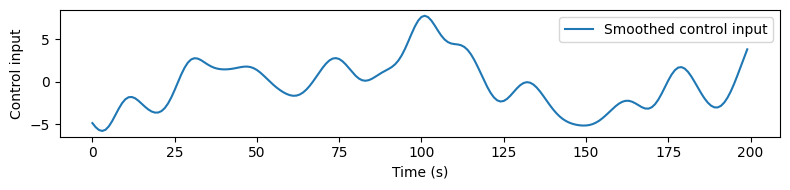

In [32]:
import numpy as np
from scipy.ndimage import uniform_filter1d, gaussian_filter1d

def generate_gaussian_smooth_controls(T, N=1, nu=1, std=1.0, sigma_range=[0.5, 2.0]):
    """
    Generate N smooth random control trajectories using a Gaussian filter.

    Parameters:
        T (int): Number of timesteps
        nu (int): Control dimension
        N (int): Number of trajectories
        std (float): Amplitude of noise
        sigma (float): Std of Gaussian kernel (controls smoothness)
        scale (float): Final scaling factor

    Returns:
        u (ndarray): Smooth controls, shape (N, T, nu)
    """
    u_raw = np.random.randn(N, T, nu) * std
    u_smooth = np.zeros_like(u_raw)
    
    sigmas = np.random.uniform(sigma_range[0], sigma_range[1], size=(N,))
    
    # Apply gaussian_filter1d over time axis (axis=1) for each control dimension
    for n in range(N):
        for i in range(nu):
            u_smooth[n, :, i] = gaussian_filter1d(u_raw[n, :, i], sigma=sigmas[n], mode="nearest")

    return u_smooth

T = 200
us = generate_gaussian_smooth_controls(T, nu=1, N=5000, std=10.0, sigma_range=(2,10))
print(us.shape)

fig, ax = plt.subplots(1,1, figsize=(8, 2))
ax.plot(us[0, ...], label='Smoothed control input')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Control input')
ax.legend()
plt.tight_layout()
plt.show()